# Product Trend & Sentiment Analysis – Underneat.in

-----
This Demonstration shows how to:
- Scrape product data from Underneat.in
- Extract trends like "New Arrivals" and "Best Sellers"
- Perform sentiment analysis on product titles
- Analyze pricing, discounting, and product categories
- Visualize insights using charts

-----
This serves as a prototype for scalable trend analysis across fashion websites and marketplaces.

In [1]:
# Module used
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import time
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Headers to avoid getting blocked
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

BASE_URL = "https://underneat.in"
sections = {
    "All Products": "/collections/all-products",
    "Best Sellers": "/collections/best-selling",
    "New Arrivals": "/collections/new-arrivals"
}

In [3]:
# Getting sentiment polarity from product title
def get_sentiment(text):
    blob = TextBlob(text)
    return round(blob.sentiment.polarity, 3)  # from -1 (negative) to +1 (positive)

# Extracting product info from HTML block
def extract_product_info(product, section_name):
    try:
        name = product.select_one(".product-block__title").get_text(strip=True)
        price_tag = product.select_one(".price__current")
        if not price_tag:
            return None
        price = price_tag.get_text(strip=True).replace("Rs.", "").replace(",", "")
        url_suffix = product.select_one("a.product-link")["href"]
        full_url = BASE_URL + url_suffix

        category = url_suffix.split("/")[2] if len(url_suffix.split("/")) > 2 else "Unknown"

        original_price_tag = product.select_one(".price__was")
        discount = None
        if original_price_tag:
            original_price = original_price_tag.get_text(strip=True).replace("Rs.", "").replace(",", "")
            discount = round((float(original_price) - float(price)) / float(original_price) * 100, 2)

        # Tag trend type
        if section_name == "New Arrivals":
            trend_type = "Current Trend"
        elif section_name == "Best Sellers":
            trend_type = "All-Time Popular"
        else:
            trend_type = "General"

        return {
            "Product Name": name,
            "Price (INR)": float(price),
            "Product URL": full_url,
            "Category": category,
            "Discount (%)": discount,
            "Section": section_name,
            "Trend Type": trend_type,
            "Sentiment Score": get_sentiment(name),
            "Time Captured": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    except Exception as e:
        print(f"Error parsing product: {e}")
        return None

In [4]:
def scrape_section(name, path):
    page = 1
    all_products = []
    while True:
        url = f"{BASE_URL}{path}?page={page}"
        print(f"Fetching: {url}")
        res = requests.get(url, headers=headers)
        soup = BeautifulSoup(res.text, "html.parser")
        products = soup.select(".product-block")
        if not products:
            break
        for p in products:
            info = extract_product_info(p, name)
            if info:
                all_products.append(info)
        page += 1
        time.sleep(1)  # Be polite
    return pd.DataFrame(all_products)

In [5]:
dfs = {}
for section, path in sections.items():
    print(f"\nScraping Section: {section}")
    dfs[section] = scrape_section(section, path)

# Combining all sections into one DataFrame
final_df = pd.concat(dfs.values(), ignore_index=True)

# Saving it to CSV file
final_df.to_csv("underneat_trending_products.csv", index=False)
print("\n Scraping Complete. Data saved to 'underneat_trending_products.csv'")

# Preview
final_df.head()


Scraping Section: All Products
Fetching: https://underneat.in/collections/all-products?page=1
Fetching: https://underneat.in/collections/all-products?page=2
Fetching: https://underneat.in/collections/all-products?page=3

Scraping Section: Best Sellers
Fetching: https://underneat.in/collections/best-selling?page=1
Fetching: https://underneat.in/collections/best-selling?page=2

Scraping Section: New Arrivals
Fetching: https://underneat.in/collections/new-arrivals?page=1
Fetching: https://underneat.in/collections/new-arrivals?page=2

 Scraping Complete. Data saved to 'underneat_trending_products.csv'


,Product Name,Price (INR),Product URL,Category,Discount (%),Section,Trend Type,Sentiment Score,Time Captured
0,Strapless Butt Lifting Bodysuit,2199.0,https://underneat.in/products/strapless-butt-l...,strapless-butt-lifting-bodysuit,None,All Products,General,0.00,2025-07-18 15:40:06
1,All Day Push Up Bra,1499.0,https://underneat.in/products/all-day-push-up-bra,all-day-push-up-bra,None,All Products,General,0.00,2025-07-18 15:40:06
2,High Waist Tummy Control Shorts,1999.0,https://underneat.in/products/high-waist-tummy...,high-waist-tummy-control-shorts,None,All Products,General,0.16,2025-07-18 15:40:06
3,Open Bust Butt Lifting Bodysuit,2699.0,https://underneat.in/products/open-butt-liftin...,open-butt-lifting-bodysuit,None,All Products,General,0.00,2025-07-18 15:40:06
4,High Waist Butt Lifting Shorts,1799.0,https://underneat.in/products/high-waist-butt-...,high-waist-butt-lifting-shorts,None,All Products,General,0.16,2025-07-18 15:40:06


-----
## Visual Insights

We now visualize the collected product data to extract deeper insights.
- Sentiment distribution across product names
- Average price by trend type
- Product count per section
- Sentiment vs. Price comparison

-----

### Sentiment Score Distribution

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


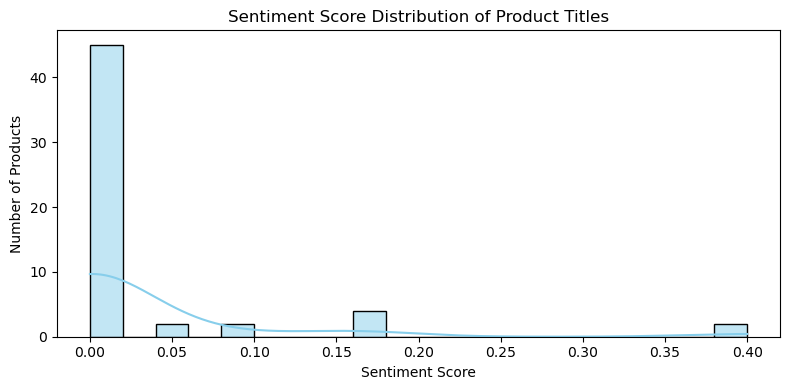

In [6]:
plt.figure(figsize=(8, 4))
sns.histplot(final_df["Sentiment Score"], bins=20, kde=True, color="skyblue")
plt.title("Sentiment Score Distribution of Product Titles")
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Products")
plt.tight_layout()
plt.show()

### Average Price by Trend Type

/var/folders/f_/4c4tkmj90gb20rdrw1vfpf_m0000gn/T/ipykernel_39133/2084468061.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=final_df, x="Trend Type", y="Price (INR)", ci=None, palette="Set2")


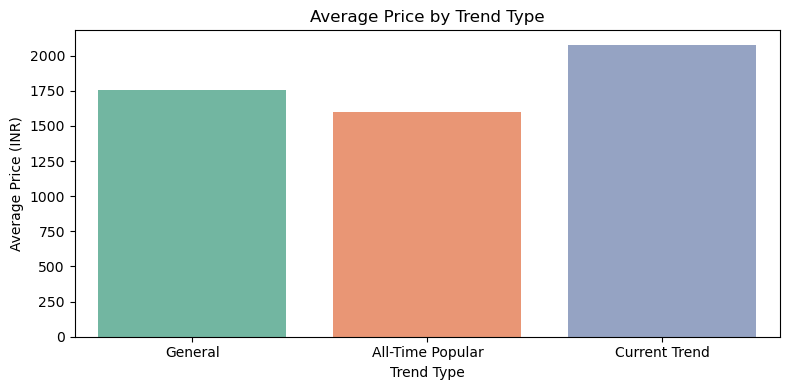

In [7]:
plt.figure(figsize=(8, 4))
sns.barplot(data=final_df, x="Trend Type", y="Price (INR)", ci=None, palette="Set2")
plt.title("Average Price by Trend Type")
plt.ylabel("Average Price (INR)")
plt.xlabel("Trend Type")
plt.tight_layout()
plt.show()

### Product Count by Section

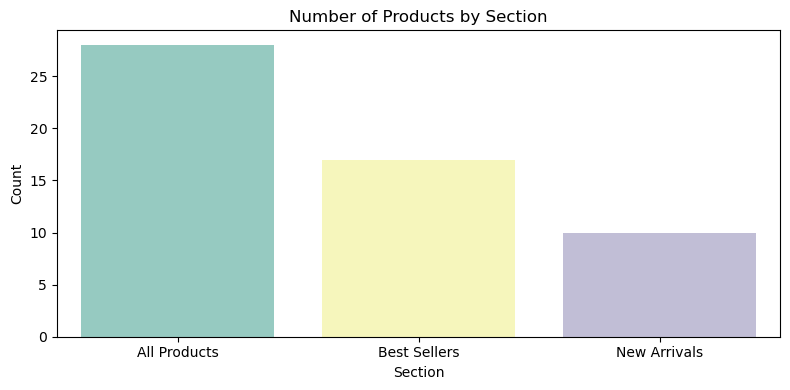

In [8]:
plt.figure(figsize=(8, 4))
sns.countplot(data=final_df, x="Section", palette="Set3")
plt.title("Number of Products by Section")
plt.ylabel("Count")
plt.xlabel("Section")
plt.tight_layout()
plt.show()

###  Sentiment vs Price Scatterplot

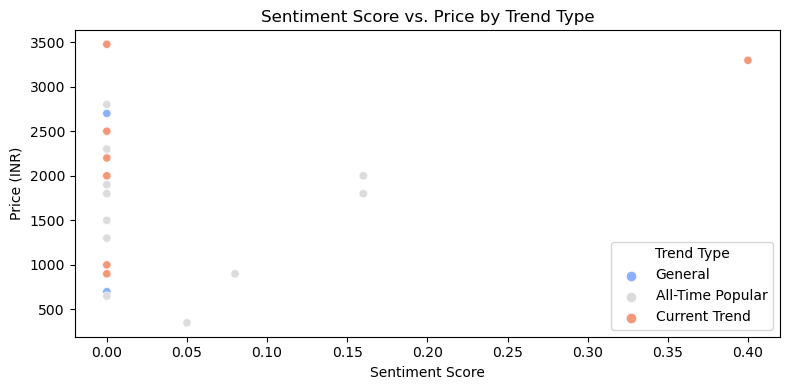

In [9]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=final_df, x="Sentiment Score", y="Price (INR)", hue="Trend Type", palette="coolwarm")
plt.title("Sentiment Score vs. Price by Trend Type")
plt.tight_layout()
plt.show()

### Top 5 Current Trend Products (New Arrivals)

In [10]:
# Filter current trends
df_current = final_df[final_df["Trend Type"] == "Current Trend"]

# Top 5 by sentiment
top5 = df_current.sort_values(by="Sentiment Score", ascending=False).head(5)
top5 = top5[["Product Name", "Price (INR)", "Sentiment Score", "Product URL"]]
top5

,Product Name,Price (INR),Sentiment Score,Product URL
50,Sculpt Fit Padded Shorts,3295.0,0.4,https://underneat.in/products/sculpt-fit-padde...
45,Strapless Butt Lifting Bodysuit,2199.0,0.0,https://underneat.in/products/strapless-butt-l...
46,All Day Hold Strapless Bra,2499.0,0.0,https://underneat.in/products/all-day-hold-str...
47,Reusable Breast Lift Cup-Comma Bunny Ups,999.0,0.0,https://underneat.in/products/comma-bunny-ups
48,Built in bra bodycon dress,2499.0,0.0,https://underneat.in/products/skin-fit-bodycon...


## Market Research Insights — Top 5 Trendy Products

---

### 1. Sculpt Fit Padded Shorts
- **Target Audience:** Active women aged 20–35 looking for stylish performance wear.
- **Pricing Strategy:** ₹3295 — positioned as premium athleisure, possibly using influencers or fitness ambassadors.
- **Competitive Landscape:** Nike Dri-Fit, Adidas Formotion, HRX Sculpt Series.

---

### 2. Strapless Butt Lifting Bodysuit
- **Target Audience:** Women aged 22–40 seeking shapewear for parties or events.
- **Pricing Strategy:** ₹2199 — mid-premium shapewear pricing, targets functionality + aesthetics.
- **Competitive Landscape:** Clovia, Shapellx, Zivame Sculpt Collection.

---

### 3. All Day Hold Strapless Bra
- **Target Audience:** Young professionals and fashion-conscious women, 20–35, who wear strapless/halter outfits.
- **Pricing Strategy:** ₹2499 — priced in premium lingerie tier, promotes comfort and stability.
- **Competitive Landscape:** Enamor, Hunkemöller, Victoria's Secret Light Lift.

---

### 4. Reusable Breast Lift Cup — Comma Bunny Ups
- **Target Audience:** Women 18–35 who want invisible support under dresses or gowns.
- **Pricing Strategy:** ₹999 — affordable, reusable solution for occasional wear.
- **Competitive Landscape:** Amazon Basics, Sneak Peek Nipple Covers, Hollywood Fashion Secrets.

---

### 5. Front Zip Thong Bodysuit
- **Target Audience:** Women 22–38 exploring edgy or modern fashion styling, partywear.
- **Pricing Strategy:** ₹1999 — affordable boldwear; often cross-sold with skirts or blazers.
- **Competitive Landscape:** Shein, Zara Bodysuits, Urbanic Shapewear.



-----
## Summary

- Scraped product listings from Underneat.in across 3 sections.
- Calculated sentiment scores for product names using TextBlob.
- Analyzed trends, pricing, and discounting.
- Visualized sentiment, price, and trend distribution.

-----

-----
### Next Steps should be (if more time allowed):
- Extend the same logic to Nykaa Fashion, Myntra, TheHouseOfRare.com
- Add review scraping for better sentiment scoring
- Store all data in a PostgreSQL/MySQL
- Build a dashboard in Streamlit or Tableau
-----

## Database Design (ER Diagram / Table Structure)

To support scalable storage of trend and sentiment data:

-----

### Tables we need:
1. `products`
   - product_id (PK)
   - product_name
   - category
   - base_url
  
-----

2. `trend_data`
   - trend_id (PK)
   - product_id (FK)
   - section (New Arrival, Best Seller, etc.)
   - trend_type (current/historical)
   - timestamp

-----

3. `sentiment_scores`
   - sentiment_id (PK)
   - product_id (FK)
   - sentiment_score
   - captured_at
  
-----

4. `market_research`
   - research_id (PK)
   - product_id (FK)
   - target_audience
   - pricing_strategy
   - competitors

-----